In [1]:
from influxdb import InfluxDBClient
from datetime import datetime
import numpy as np
import time
import matplotlib.pyplot as plt
# from influxdb_client import InfluxDBClient

In [2]:
# client = InfluxDBClient(url='127.0.0.1', port=8086, username='kirilman', password='blue', database='stocks')
client = InfluxDBClient(host='127.0.0.1', port=8086, username='kirilman', password='blue')

In [3]:
ans = client.query("SELECT * FROM current_prices WHERE ticker = '{}' and time > now() - {}d;".format('SAVE', 71), 
                                          database='current_prices')

In [4]:
stats =  list(ans)[0]
print(len(stats))
stats[0]

265


{'time': '2020-09-03T12:44:59.692199Z', 'close': 17.61, 'ticker': 'SAVE'}

In [9]:
stats_ans = client.query("SELECT * FROM current_prices WHERE time > now() - 68h", database='current_prices') 
l = list(stats_ans)
# [-1]
print(len(l))

# c_price = list(stats_ans.get_points(tags={'ticker':'SAVE'}))
c_price = list(stats_ans.get_points(tags={'ticker':'SAVE'}))[-5:]
c_price

1


[{'time': '2020-09-03T13:30:34.992552Z', 'close': 18.04, 'ticker': 'SAVE'},
 {'time': '2020-09-03T13:30:45.040182Z', 'close': 17.87, 'ticker': 'SAVE'},
 {'time': '2020-09-03T13:30:55.097005Z', 'close': 17.93, 'ticker': 'SAVE'},
 {'time': '2020-09-03T13:31:05.093124Z', 'close': 18.04, 'ticker': 'SAVE'},
 {'time': '2020-09-03T13:31:15.125288Z', 'close': 18.05, 'ticker': 'SAVE'}]

In [7]:
%time stats_ans = client.query("SELECT * FROM statics WHERE time > now() - 1m GROUP BY ticker", database='statics') 
print(len(list(stats_ans)[0]))

#Разбираем запрос
stats = {}
for s in stats_ans.raw['series']:
    d = {}
    for i, name in enumerate(s['columns']):
        d.update({name:s['values'][-1][i]})
    stats[s['tags']['ticker']] = d

stats['XOM']['max']

CPU times: user 5.46 ms, sys: 119 µs, total: 5.58 ms
Wall time: 11.2 ms


IndexError: list index out of range

In [667]:
prices_ans = client.query("SELECT * FROM current_prices WHERE time > now() - 930m", database='current_prices')

# prices_ans = client.query("SELECT * FROM current_prices WHERE time > now() - 60m", database='current_prices')
prices_ans.raw['series'][0]['values']
len(list(prices_ans)[0])

82

In [499]:
%time c_stat = list(stats_ans.get_points(tags={'ticker':'AMD'}))
c_stat

CPU times: user 4.36 ms, sys: 7 µs, total: 4.37 ms
Wall time: 4.09 ms


[{'time': '2020-06-17T09:53:58.878589Z',
  'max': 59.5,
  'max_day': 56.0,
  'max_month': 58.99,
  'max_week': 58.99,
  'min': 2.0,
  'min_day': 52.3,
  'min_month': 2.0,
  'min_week': 51.6,
  'price': 54.36,
  'procent_to_round': -0.66,
  'round_price': 54},
 {'time': '2020-06-17T09:54:48.027598Z',
  'max': 59.5,
  'max_day': 56.0,
  'max_month': 58.99,
  'max_week': 58.99,
  'min': 2.0,
  'min_day': 52.3,
  'min_month': 2.0,
  'min_week': 51.6,
  'price': 54.36,
  'procent_to_round': -0.66,
  'round_price': 54}]

In [331]:
prices_ans = client.query("SELECT * FROM current_prices WHERE time > now() - 5m", database='current_prices')
%time c_price = list(prices_ans.get_points(tags={'ticker':'AMD'}))[-1]
print(c_price)

CPU times: user 8.04 ms, sys: 0 ns, total: 8.04 ms
Wall time: 9.64 ms
{'time': '2020-06-17T09:37:43.070546Z', 'close': 54.7, 'ticker': 'AMD'}


In [231]:
ans = client.query("SELECT * FROM stocks WHERE ticker = '{}' and time > now() - 2d;".format('AMD'),
                   database='stocks')
l =list(ans)

In [ ]:
def query(tickers):
#     ans = client.query("SELECT * FROM stocks WHERE \"ticker\" = \"{}\" time > now() - 30d;".format(ticker))
    for ticker in tickers:
        ans = client.query("SELECT * FROM stocks WHERE ticker = '{}' and time > now() - 60d;".format(ticker))
        if len(ans) == 0:
            continue
        items = list(ans)[0]
        closes = np.array([c['close'] for c in items])
        print(closes.max(), len(ans))
    return closes
%time a = query(['DAL'])
print(a.max(), a.min())

In [114]:
client.query("DELETE FROM current_prices",database='current_prices')

ResultSet({})

In [ ]:
ans = client.query("SELECT * FROM stocks WHERE ticker = '{}' and time > now() - {}d;".format('AMD', 3), 
                                          database='stocks')
candles = list(ans)[0]
closes = np.array([c['close'] for c in candles])
closes

In [ ]:
json_body = [
    {
        "measurement": "stocks",
        "tags": {
            "ticker": "AMD",
            "interval": "5min"
        },
        "time": datetime.now().isoformat('T'),
        "fields": {
            "open" : 1.11,
            "close": 2.,
        }
    }
]
client.write_points(json_body)

In [ ]:
import os
from datetime import datetime, timedelta
# from urllib.parse import urlencode
# from urllib.request import urlopen
import sys
sys.path.append('../')
from time import sleep
import time
from multiprocessing import Process
from urllib.error import HTTPError
from openapi_genclient import exceptions

from openapi_client import openapi
from FIGIS import Market_names

class Market_Downloader():
    def __init__(self):
        self.token = "t.wlnxazSuK6W--U6od2e6k778AW3nfY7MPm-1h93rzYXl6JIVPTnODfaeaJz1EjhfWl6XnJn2MCmIlqJPeeF6tg"
        client = openapi.sandbox_api_client(self.token)
        client.sandbox.sandbox_register_post()
        self.market_api = client.market
        ans = self.market_api.market_search_by_ticker_get('AMD')
        print(ans)
        self.market_names = Market_names()

    def download_market_candles(self, save_dir, ticker, _from, to, interval):
        """
            _from : 2019-08-19T18:38:33.131642+03:00
            interval: ("1min","5min","day")
        """
        figi = self.market_names.get_figi_by_name(ticker)
        print(figi)
        if figi is None:
            print('Не найден FIGI для', ticker)
            return 
        ans = self.market_api.market_candles_get(figi, _from, to, interval)
        candles = ans.payload.candles
        full_path = save_dir + ticker+'.txt'
        f = open(full_path,'w')
        f.write('<OPEN>;<HIGH>;<LOW>;<CLOSE>;<VOL>\n')
        for candle in candles:
            close = candle.c
            high  = candle.h
            low   = candle.l
            open_ = candle.o
            volum = candle.v
            f.write('{};{};{};{};{}\n'.format(open_, high, low, close, volum))
        f.close()
        # print(candles)
    
    def get_market_candles(self, ticker, _from, to, interval):
        figi = self.market_names.get_figi_by_name(ticker)
        if figi is None:
            print('Не найден FIGI для', ticker)
            return None
        ans = self.market_api.market_candles_get(figi, _from, to, interval)
        candles = ans.payload.candles
        if candles is not None:
            return candles
        else:
            return None


    def download_markets_from_to(self, save_dir, tickers, _from, to, interval):
        for ticker in tickers:
            try:
                self.download_market_candles(save_dir, ticker, _from, to, interval)
            except:
                print(ticker)
                sleep(5)
        
    def has_last_stocks(self, path):
        dirs = os.listdir(path)
        current_time = datetime.now() - timedelta(days=1)
        # current_time_str = current_time.strftime('%d.%m.%Y')
        day = current_time.day
        day_str = '{}'.format(day)
        if not(day_str in dirs):
            return False, [], day_str
        else:
            return True, os.listdir(path+day_str), day_str

    def get_last_day(self, tickers, market_names:Market_names):
        msk = '+03:00'
        path = './stocks last day/'

        token = "t.wlnxazSuK6W--U6od2e6k778AW3nfY7MPm-1h93rzYXl6JIVPTnODfaeaJz1EjhfWl6XnJn2MCmIlqJPeeF6tg"
        now = datetime.now()
        if now.weekday() == 0 and now.hour < 14:
            start = now - timedelta(hours = now.hour, minutes = now.minute, seconds = now.second) - timedelta(days=3)
        else:
            start = now - timedelta(hours = now.hour, minutes = now.minute, seconds = now.second) - timedelta(days=1)

        start_str = start.isoformat() + msk
        end_str = (start+timedelta(days=1)).isoformat()+msk
        
        print(start_str, end_str)
        client = openapi.sandbox_api_client(token)
        client.sandbox.sandbox_register_post()   
        def get_tickers(tickers, tickers_in_directory, day):
            minus = list(set(tickers) - set(tickers_in_directory))
            print(len(minus))
            for ticker in minus:
                sleep(0.15)
                figi = market_names.get_figi_by_name(ticker)
                # print(figi)
                if figi is None:
                    print('figi не получен ',ticker)
                    continue
                try:
                    response = client.market.market_candles_get(figi,start_str,end_str,'day')
                except exceptions.ApiException as err:
                    print('Исключение ',ticker,' ',err.reason, ' ',err.status)
                    continue
                # if response.status=="Error":
                #     continue
                candles = response._payload._candles
                if len(candles) > 1:
                    print('Получено свечей больше чем на один день!', len(candles))
                    candle = candles[-1]
                elif len(candles) == 0:
                    print('Длина ', len(candles), ticker)
                    continue
                else:
                    candle = candles[0]
                close = candle.c
                high  = candle.h
                low   = candle.l
                open_ = candle.o
                volum = candle.v
                full_path = path + day + '/' + ticker+'.txt'
                
                f = open(full_path,'w')
                f.write('<OPEN>;<HIGH>;<LOW>;<CLOSE>;<VOL>\n')
                f.write('{};{};{};{};{}'.format(open_, high, low, close, volum))
                f.close()
                
                # print(ticker, ' готов')

        flag, files, day = self.has_last_stocks(path)
        # print(flag, files, day)
        files = [x.split('.')[0] for x in files]
        try:
            if flag:
                get_tickers(tickers, files, day)
            else:
                os.mkdir(path+day)
                get_tickers(tickers, files, day)
        except Exception as exc:
            print('Error', exc, type(exc))
        return path + day + '/'


# m_loader = Market_Downloader()
# m_loader.download_market_candles('./Downloader/SPB/','AMD', '2020-05-13T16:30:00.00+04:00','2020-05-14T05:50:00.00+04:00', '5min')
# tickers = ['AMD','CCL','JPM','INTEL','OIS','AAL','DLT']

# m_loader.download_markets_from_to('./Downloader/SPB/',tickers, '2020-05-07T16:30:00.00+04:00','2020-05-14T12:40:00.00+04:00', 'hour')

In [ ]:
ans = Market_Downloader().get_market_candles('AMD','2020-05-19T06:00:00.00+00:00',
                                                   '2020-05-19T23:00:00.00+00:00','5min')
len(ans)

In [ ]:
import rfc3339
from datetime import timedelta

In [ ]:
_from = '2020-03-22T14:00:00.11'
to    = '2020-06-02T14:00:00.11'

start_date = datetime.strptime(_from.split('+')[0], '%Y-%m-%dT%H:%M:%S.%f')
end_date   = datetime.strptime(to.split('+')[0], '%Y-%m-%dT%H:%M:%S.%f')
for d in range((end_date - start_date).days):
#   from_start = '2020-05-19T06:00:00.00+00:00'
#    to_end     = '2020-05-19T23:00:00.00+00:00'
    from_start = (start_date+timedelta(d))
    tt = from_start.isoformat().split('T')[0]
    from_str = tt+'T06:00:00.00+00:00'
    to_str   = tt+'T23:00:00.00+00:00'
    print(from_str, to_str)

In [ ]:
datetime.strptime(t1, '%Y-%m-%dT%H:%M:%S.%f'  )

In [ ]:
datetime.fromisoformat(t1)

In [19]:
# %time ans = client.query("SELECT * FROM current_prices WHERE time > now() - 1d GROUP BY ticker", database='current_prices')
%time ans = client.query("SELECT * FROM current_prices", database='current_prices')

len(ans)

CPU times: user 359 ms, sys: 40.4 ms, total: 400 ms
Wall time: 709 ms


1

In [20]:
a =list(ans)
print(len(a), len(a[0]))

1 81467


In [21]:
list(ans.get_points(tags={'ticker':'AMD'}))[-1]

{'time': '2020-06-01T12:19:27.375204Z', 'price': 53.36, 'ticker': 'AMD'}

In [22]:
prices_ans = client.query("SELECT * FROM stocks WHERE time > now() - 1d", database='stocks')
cur_prices = list(prices_ans)[0]
print( len(cur_prices))

13333


In [23]:
list(prices_ans.get_points(tags={'ticker':'SAVE'}))[-1]

{'time': '2020-06-12T22:40:00Z',
 'close': 18.7,
 'high': 18.75,
 'interval': '5min',
 'low': 18.7,
 'open': 18.75,
 'ticker': 'SAVE',
 'volum': 864}

In [ ]:
ans = client.query("SELECT * FROM statics WHERE price > 0 and time > now() - 8d", database='statics') 
stocks =  list(ans)[0]
for s in stocks:
    print(s)

In [94]:
stats_ans  = client.query("SELECT * FROM statics WHERE price > 0 and time > now() - 1d", database='statics') 
prices_ans = client.query("SELECT * FROM stocks WHERE time > now() - 1d", database='stocks')

1592033344.331262

In [153]:
tickers = ['AAL','SAVE','AMD']
tickers=['SAVE','AAL','DAL','SPR','M','PBF','UAL','MAC','CCL','HAL','MAC','GPS']

time_values = []

n = len(tickers)
start = time.time()
for c in range(1000):
    i = np.random.randint(n)
    t =  tickers[i]
    current_time = time.time()
    prices_ans = client.query("SELECT * FROM stocks WHERE time > now()- 10h", database='stocks')
    c_price = list(prices_ans.get_points(tags={'ticker': t }))[-1]
    time_values.append(time.time() - current_time)
print(time.time() - start)
times = np.array(time_values)
times.mean()

32.03630471229553


0.031952240467071534

31.952240467071533


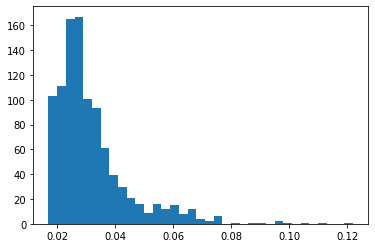

In [156]:
# old = times
print(times.mean()*1000)
plt.hist(times,35);

In [99]:
%time prices_ans = client.query("SELECT * FROM stocks WHERE time > now()- 12h", database='stocks')
prices_ans['stocks']

CPU times: user 28.1 ms, sys: 3.88 ms, total: 32 ms
Wall time: 74.2 ms


<generator object ResultSet.get_points at 0x7f6b70f6ded0>

In [114]:
%time c_price = list(prices_ans.get_points(tags={'ticker':'SAVE'}))[-1]
c_price

CPU times: user 42 ms, sys: 3.95 ms, total: 45.9 ms
Wall time: 43.9 ms


{'time': '2020-06-12T22:40:00Z',
 'close': 18.7,
 'high': 18.75,
 'interval': '5min',
 'low': 18.7,
 'open': 18.75,
 'ticker': 'SAVE',
 'volum': 864}

In [ ]:
stocks = list(stats_ans)[0]
tickers = [s['ticker'] for s in list(stats_ans)[0]]

In [ ]:
list(prices_ans.get_points(tags={'ticker':'AMD'}))[-1]

In [ ]:
def calculate_procents(prices_ans,stats_ans):
    stats = []
    tickers = [s['ticker'] for s in list(stats_ans)[0]]
    for ticker in tickers:
        c_stat = list(stats_ans.get_points(tags={'ticker':ticker}))[0]
        c_price = list(prices_ans.get_points(tags={'ticker':ticker}))[-1]
        d = {'ticker'   : ticker,            
             'min_prnt' : (c_price['close']/c_stat['min'] - 1)*100,
             'min_day'  : (c_price['close']/c_stat['min_day'] - 1)*100,
             'min_month': (c_price['close']/c_stat['min_month'] - 1)*100,
             'min_week' : (c_price['close']/c_stat['min_week'] - 1)*100,
             'max_day'  : (c_price['close']/c_stat['max_day'] - 1)*100,
             'max_week' : (c_price['close']/c_stat['max_week'] - 1)*100,
             'max_month': (c_price['close']/c_stat['max_month'] - 1)*100,
             'max_prnt' : (c_price['close']/c_stat['max'] - 1)*100,
        }
        stats+=[d]
    return stats

In [ ]:
%time d = calculate_procents(prices_ans,stats_ans)

In [ ]:
prices_ans.get_points(tags={'ticker':ticker})

In [ ]:
%time list(prices_ans.get_points(tags={'ticker':ticker}))[-1]

In [ ]:
tickers = [s['ticker'] for s in list(stats_ans)[0]]
for ticker in tickers:
    c_stat = list(stats_ans.get_points(tags={'ticker':ticker}))[0]
    c_price = list(prices_ans.get_points(tags={'ticker':ticker}))[-1]
    print(c_price['ticker'], c_price['close'], c_stat['max'])

In [263]:
ans = client.query("SELECT * FROM statics WHERE price > 0 and time > now() - 1222h", database='statics') 
stats = list(ans)

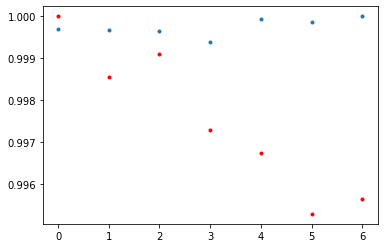

In [267]:
sp = np.array(sp[:-1])
save = np.array(save[:-1])
sp = sp/sp.max()
save = save/save.max()
plt.plot(sp,'.')
plt.plot(save,'.',color='red')

In [268]:
sp

array([0.99969461, 0.99966916, 0.99964689, 0.99939558, 0.99993638,
       0.99985685, 1.        ])